In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm

/Users/joyliu/anaconda3/envs/compsci371/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
df = pd.read_csv('3artist.csv')
df.head()
df['tokens'] = df['clean_lyrics'].apply(lambda x: x.split())

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

100%|██████████| 180/180 [00:04<00:00, 36.46it/s]


Logistic Regression Evaluation
Accuracy: 0.839
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.82      0.70      0.76        60
       Drake       0.89      0.97      0.93        60
Taylor Swift       0.80      0.85      0.82        60

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180



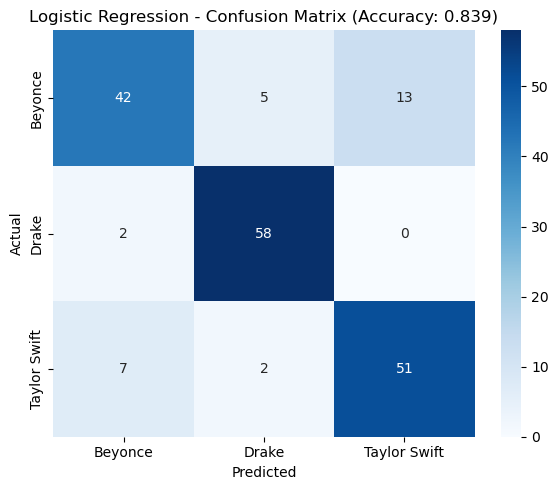

SVM Evaluation
Accuracy: 0.828
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.82      0.68      0.75        60
       Drake       0.88      0.93      0.90        60
Taylor Swift       0.79      0.87      0.83        60

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.82       180
weighted avg       0.83      0.83      0.82       180



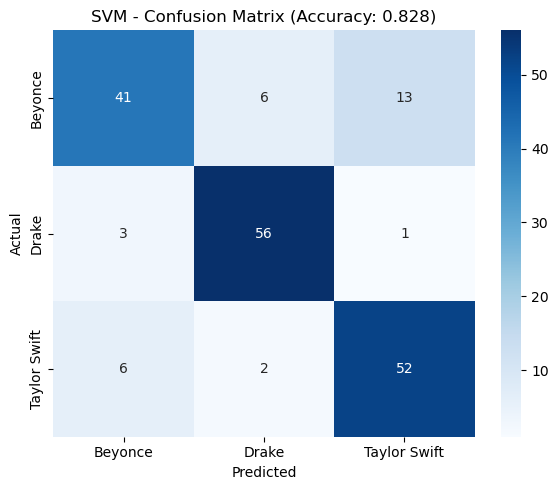

Random Forest Evaluation
Accuracy: 0.767
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.69      0.68      0.69        60
       Drake       0.89      0.85      0.87        60
Taylor Swift       0.72      0.77      0.74        60

    accuracy                           0.77       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.77      0.77      0.77       180



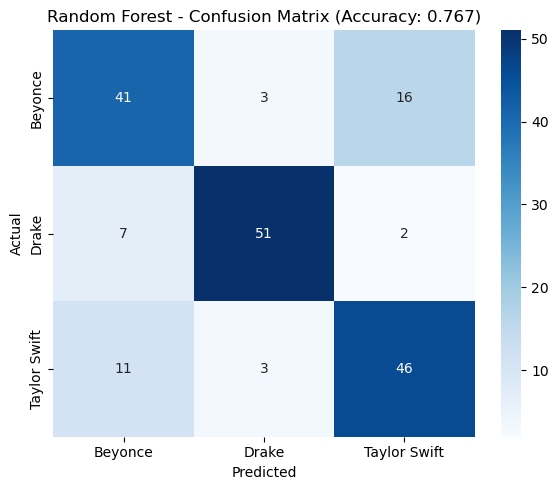

Naive Bayes Evaluation
Accuracy: 0.7
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.64      0.63      0.64        60
       Drake       0.75      0.85      0.80        60
Taylor Swift       0.70      0.62      0.65        60

    accuracy                           0.70       180
   macro avg       0.70      0.70      0.70       180
weighted avg       0.70      0.70      0.70       180



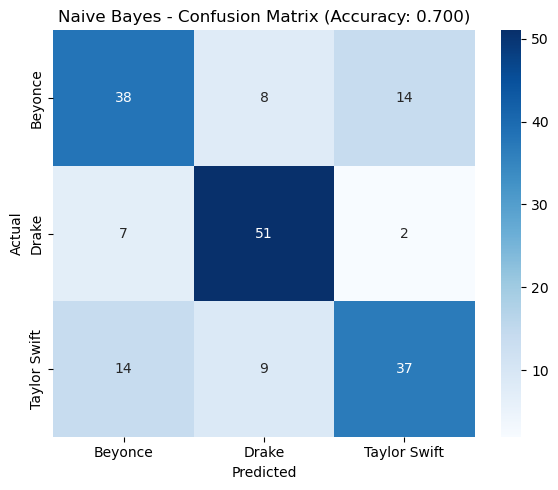

In [6]:
def get_bert_mean_embeddings(texts, tokenizer, model, max_length=128):
    embeddings = []
    for text in tqdm(texts):
        encoded_input = tokenizer(text, padding='max_length', truncation=True,
                                  max_length=max_length, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        # Mean pooling across all tokens
        mean_embedding = output.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(mean_embedding)
    return np.array(embeddings)


le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_lyrics'], df['encoded_label'], test_size=0.2, stratify=df['encoded_label'], random_state=42
)

X_train_vec = get_bert_mean_embeddings(X_train_text.tolist(), tokenizer, bert_model)
X_test_vec = get_bert_mean_embeddings(X_test_text.tolist(), tokenizer, bert_model)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}



for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Evaluation")
    print("Accuracy:", round(acc, 3))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Matplotlib + Seaborn confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix (Accuracy: {acc:.3f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Fine Tuning

In [7]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import DistilBertTokenizerFast
from transformers import TrainingArguments

In [8]:
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [12]:
drake_df = pd.read_csv("Drake.csv")
taylor_df = pd.read_csv("TaylorSwift.csv")
beyonce_df = pd.read_csv("Beyonce.csv", engine='python')

# Basic cleaning
def simple_clean(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text
df = pd.concat([
    pd.read_csv("Drake.csv")[['Lyric']].dropna().sample(300, random_state=42).assign(label='Drake'),
    pd.read_csv("TaylorSwift.csv")[['Lyric']].dropna().sample(300, random_state=42).assign(label='Taylor Swift'),
    pd.read_csv("Beyonce.csv", engine='python')[['Lyric']].dropna().sample(300, random_state=42).assign(label='Beyonce')
], ignore_index=True)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return re.sub(r"\s+", " ", text).strip()

df['clean_lyrics'] = df['Lyric'].apply(clean_text)
df['label_encoded'] = LabelEncoder().fit_transform(df['label'])

# Step 3: Train/Test Split using Pandas (stratified)
train_df, test_df = train_test_split(
    df[['clean_lyrics', 'label_encoded']], 
    stratify=df['label_encoded'], 
    test_size=0.2, 
    random_state=42
)

Map: 100%|██████████| 180/180 [00:00<00:00, 3598.42 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.099500
20,1.056200
30,0.978300
40,0.984500
50,0.782100
60,0.805900
70,0.722600
80,0.731000
90,0.602600
100,0.607400



Classification Report:

              precision    recall  f1-score   support

     Beyonce       0.82      0.70      0.76        60
       Drake       0.87      0.90      0.89        60
Taylor Swift       0.81      0.90      0.85        60

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.83      0.83      0.83       180



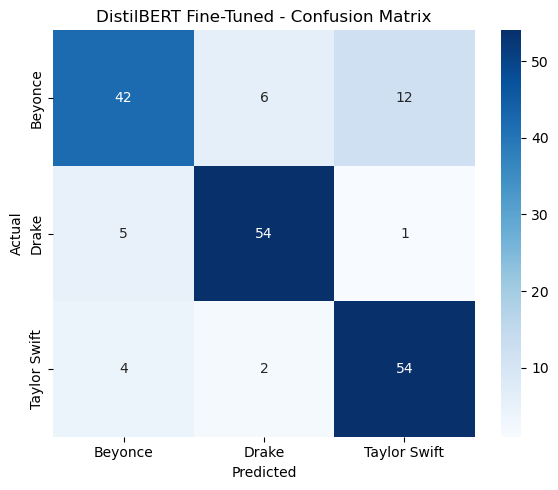

In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['clean_lyrics'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df.rename(columns={'label_encoded': 'labels'}))
test_dataset = Dataset.from_pandas(test_df.rename(columns={'label_encoded': 'labels'}))

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Step 5: Load DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=3  # Drake, Taylor Swift, Beyonce
)

# Step 6: Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# Accuracy metric for Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

# Step 7: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Step 8: Fine-tune!
trainer.train()

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=LabelEncoder().fit(df['label']).classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEncoder().fit(df['label']).classes_, yticklabels=LabelEncoder().fit(df['label']).classes_)
plt.title("DistilBERT Fine-Tuned - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()